[Update Aug 2020 Mengyan Zhang]

This notebook implements regression on the first round results with repeated kfold.

# Pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Repeated Kfold: (n_repeated: 10; n_split/kfold: 5)
    - Kernel: weighted degree kernel with shift
        - kernel normalisation: centering and unit norm
        - lmer: number of substring [3,4,5,6]
    - Gaussian process regression 
        - alpha: scalar value add to diagonal 
- Evaluation
   - metric: e.g. Mean square error; R2
   - true label: either sample or mean of sample. 

# Key Notes

## Splitting over sequences

The training and testing data should be split in terms of sequences rather than samples, since we hope to have good predictions on unseen data. Similar idea as shown in [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html).

## Training with multiple labels vs. sample mean?

We now training with multiple labels, i.e. repeated sequences inputs with different labels (replicates).
It worth thinking whether it is equivalent to use the sample mean directly.


## Evaluate on samples vs sample mean?

For evaluation (on both training and testing predictions), we evaluate using "samples" or "averages", indicating by "eva_on" parameter. 

## What matters

The recommendations at the end it what matters, so once we choose certain parameters, we should focus on how it changes our recommendations.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
kernel_dict = {
#     'Spectrum_Kernel': Spectrum_Kernel,
#     'Mixed_Spectrum_Kernel': Mixed_Spectrum_Kernel,
#     'WD_Kernel': WeightedDegree_Kernel,
#     'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel,
    'WD_Kernel_Shift': WD_Shift_Kernel
    
}

In [3]:
Path = '../../data/Results_Microplate_partialFalse_normTrue_roundRep_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,...,Rep5,Rep6,Rep7,Rep8,Rep9,AVERAGE,STD,Pred Mean,Pred Std,Pred UCB
0,0,RBS_1by1_0,reference,First_Plate,0,TTTAAGAAGGAGATATACAT,AGGAGA,2.433056,2.502155,2.315237,...,2.917124,2.275329,NaN,NaN,NaN,2.575968,0.313540,NaN,NaN,NaN
1,1,RBS_1by1_1,bps_noncore,First_Plate,0,CTTAAGAAGGAGATATACAT,AGGAGA,1.556251,1.654243,1.762146,...,2.312790,1.959275,NaN,NaN,NaN,1.839138,0.268820,NaN,NaN,NaN
2,2,RBS_1by1_2,bps_noncore,First_Plate,0,GTTAAGAAGGAGATATACAT,AGGAGA,0.603551,0.748674,0.921939,...,0.503846,0.711231,NaN,NaN,NaN,0.646754,0.188587,NaN,NaN,NaN
3,3,RBS_1by1_3,bps_noncore,First_Plate,0,ATTAAGAAGGAGATATACAT,AGGAGA,1.658359,1.874275,1.534988,...,1.747116,1.232548,NaN,NaN,NaN,1.598899,0.220191,NaN,NaN,NaN
4,4,RBS_1by1_4,bps_noncore,First_Plate,0,TCTAAGAAGGAGATATACAT,AGGAGA,1.545942,2.072095,1.386300,...,1.774833,2.146898,NaN,NaN,NaN,1.812638,0.300722,NaN,NaN,NaN
5,5,RBS_1by1_5,bps_noncore,First_Plate,0,TGTAAGAAGGAGATATACAT,AGGAGA,0.140540,0.113415,0.428642,...,0.201247,0.349550,NaN,NaN,NaN,0.219540,0.139196,NaN,NaN,NaN
6,6,RBS_1by1_6,bps_noncore,First_Plate,0,TATAAGAAGGAGATATACAT,AGGAGA,1.263922,1.295816,0.921114,...,1.225523,1.667016,NaN,NaN,NaN,1.203763,0.294206,NaN,NaN,NaN
7,7,RBS_1by1_8,bps_noncore,First_Plate,0,TTGAAGAAGGAGATATACAT,AGGAGA,1.506111,1.663509,NaN,...,1.795683,2.231638,NaN,NaN,NaN,1.841263,0.285769,NaN,NaN,NaN
8,8,RBS_1by1_9,bps_noncore,First_Plate,0,TTAAAGAAGGAGATATACAT,AGGAGA,0.457305,0.602012,1.358909,...,0.281771,0.446837,NaN,NaN,NaN,0.584317,0.394363,NaN,NaN,NaN
9,9,RBS_1by1_10,bps_noncore,First_Plate,0,TTTCAGAAGGAGATATACAT,AGGAGA,1.470120,0.929044,0.610260,...,1.210712,1.921650,NaN,NaN,NaN,1.276187,0.464689,NaN,NaN,NaN


In [4]:
#df = df[df['Group'] != 'bps'].reset_index()
df.shape

(266, 21)

(array([17., 45., 39., 39., 37., 52., 20.,  7.,  5.,  5.]),
 array([-1.71864371, -1.27497866, -0.8313136 , -0.38764855,  0.0560165 ,
         0.49968156,  0.94334661,  1.38701167,  1.83067672,  2.27434178,
         2.71800683]),
 <a list of 10 Patch objects>)

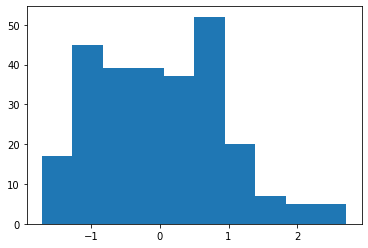

In [5]:
plt.hist(df['AVERAGE'])

# Repeated KFold 

In [6]:
kernel = 'WD_Kernel_Shift'
eva_metric = [mean_squared_error, r2_score]

gpr = GPR_Predictor(df, kernel_name = kernel)

In [7]:
# test para
# num_split = 5
# num_repeat = 2
# s_list = [0]
# # alpha_list = [0.5]
# alpha_list= [2]
# # alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
# l_list = [6] 
# sigma_0_list = [1,2]

In [8]:
num_split = 5
num_repeat = 5
s_list = [0,1]
# alpha_list = [0.5]
alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5] 
# alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
l_list =[3,4,5,6]
# sigma_0_list = [0.5, 1, 1.5, 2, 2.5]
sigma_0_list = [1]
                                                                                                         
result_DataArray = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                      l_list = l_list, s_list = s_list, sigma_0_list = sigma_0_list)

Repeated KFold Running ...


IntProgress(value=0, max=1200)

l!
init kernel
740
USE non-normalised kernel!
init kernel
741
USE non-normalised kernel!
init kernel
742
USE non-normalised kernel!
init kernel
743
USE non-normalised kernel!
init kernel
744
USE non-normalised kernel!
init kernel
745
USE non-normalised kernel!
init kernel
746
USE non-normalised kernel!
init kernel
747
USE non-normalised kernel!
init kernel
748
USE non-normalised kernel!
init kernel
749
USE non-normalised kernel!
init kernel
750
USE non-normalised kernel!
init kernel
751
USE non-normalised kernel!
init kernel
752
USE non-normalised kernel!
init kernel
753
USE non-normalised kernel!
init kernel
754
USE non-normalised kernel!
init kernel
755
USE non-normalised kernel!
init kernel
756
USE non-normalised kernel!
init kernel
757
USE non-normalised kernel!
init kernel
758
USE non-normalised kernel!
init kernel
759
USE non-normalised kernel!
init kernel
760
USE non-normalised kernel!
init kernel
761
USE non-normalised kernel!
init kernel
762
USE non-normalised kernel!
init ker

In [9]:
import pickle

with open('repeated_kfold_wd_shift_round01_without_kernelNorm.pickle', 'wb') as handle:
    pickle.dump(result_DataArray, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('repeated_kfold_wd_shift_round01_without_kernelNorm.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [10]:
result_pkl.loc[dict(train_test = 'Test')]

<xarray.DataArray (eva_on: 2, eva_metric: 2, alpha: 6, l: 4, s: 2, sigma_0: 1, num_repeat: 5, num_split: 5)>
array([[[[[[[[ 9.24289234e-01,  9.01647068e-01,  7.50037015e-01,
               7.48188130e-01,  1.07783829e+00],
             [ 8.22387124e-01,  1.05956936e+00,  8.96445274e-01,
               8.07466357e-01,  9.25179825e-01],
             [ 8.80610417e-01,  8.99888154e-01,  8.81224726e-01,
               8.82332617e-01,  1.01133344e+00],
             [ 9.47268270e-01,  8.02177522e-01,  9.69607968e-01,
               8.69368848e-01,  8.30991611e-01],
             [ 9.61148045e-01,  8.66692226e-01,  8.23800924e-01,
               8.67126022e-01,  8.66411703e-01]]],


           [[[ 9.57036479e-01,  9.44124009e-01,  9.14355169e-01,
               8.75112823e-01,  8.57852327e-01],
             [ 9.39413583e-01,  8.51257207e-01,  8.74625082e-01,
               7.83508915e-01,  8.61445798e-01],
             [ 9.09025133e-01,  1.11394978e+00,  6.80957137e-01,
               9.10618782e-01,  9.74784357e-01],
             [ 9.85685092e-01,  9.57009905e-01,  9.61012433e-01,
               7.52215862e-01,  7.43114008e-01],
...
             [ 2.47782141e-01,  1.94823272e-01,  1.64309315e-01,
               3.12593070e-01,  3.75960952e-01],
             [ 2.43300604e-01,  2.32303033e-01,  2.37414249e-01,
               2.31364018e-01,  1.24727293e-01],
             [ 3.63768460e-01,  1.90658221e-01,  2.38035918e-01,
               3.45317363e-01,  1.16975140e-01],
             [ 3.30061370e-01,  2.46281655e-01,  3.29274485e-02,
               2.13554887e-01,  2.66486579e-01]]],


           [[[ 1.72020355e-01,  3.42089726e-01,  3.34646691e-01,
               3.59428063e-01, -2.18612287e-02],
             [ 2.29255468e-01,  3.59510537e-01,  1.76499262e-01,
               2.85198522e-01,  2.96461860e-01],
             [ 2.40676071e-01,  2.84144522e-01,  3.22458682e-01,
               8.23582755e-02,  1.42836626e-01],
             [-1.36964736e-02,  3.53323567e-01,  1.52340161e-01,
               3.35008269e-01,  1.63475777e-01],
             [ 3.28920267e-01,  2.40989807e-01,  7.34345123e-02,
               3.63067999e-01,  1.64239013e-01]]]]]]]])
Coordinates:
    train_test  <U5 'Test'
  * eva_on      (eva_on) <U7 'samples' 'seq'
  * eva_metric  (eva_metric) object <function mean_squared_error at 0x7f60915...
  * alpha       (alpha) float64 1e-05 0.1 0.5 1.0 2.0 5.0
  * l           (l) int64 3 4 5 6
  * s           (s) int64 0 1
  * sigma_0     (sigma_0) int64 1
  * num_repeat  (num_repeat) int64 0 1 2 3 4
  * num_split   (num_split) int64 0 1 2 3 4

In [11]:
result_pkl[1].mean(axis = -1).mean(axis = -1)

<xarray.DataArray (eva_on: 2, eva_metric: 2, alpha: 6, l: 4, s: 2, sigma_0: 1)>
array([[[[[[ 0.89092121],
           [ 0.89135979]],

          [[ 0.91719825],
           [ 0.92190899]],

          [[ 0.91841657],
           [ 0.92814791]],

          [[ 0.94064713],
           [ 0.97731357]]],


         [[[ 0.87980067],
           [ 0.89770171]],

          [[ 0.93115302],
           [ 0.90618005]],

          [[ 0.97097489],
...
           [ 0.1829558 ]],

          [[ 0.16161215],
           [ 0.20393344]],

          [[ 0.2056714 ],
           [ 0.17972137]]],


         [[[ 0.19646422],
           [ 0.21439593]],

          [[ 0.19382647],
           [ 0.21079358]],

          [[ 0.22126216],
           [ 0.22253712]],

          [[ 0.23570528],
           [ 0.23067305]]]]]])
Coordinates:
    train_test  <U5 'Test'
  * eva_on      (eva_on) <U7 'samples' 'seq'
  * eva_metric  (eva_metric) object <function mean_squared_error at 0x7f60915...
  * alpha       (alpha) float64 1e-05 0.1 0.5 1.0 2.0 5.0
  * l           (l) int64 3 4 5 6
  * s           (s) int64 0 1
  * sigma_0     (sigma_0) int64 1

(array([4., 2., 5., 3., 8., 3., 7., 3., 6., 7.]),
 array([-0.02848313, -0.00206429,  0.02435455,  0.05077339,  0.07719223,
         0.10361107,  0.13002991,  0.15644875,  0.1828676 ,  0.20928644,
         0.23570528]),
 <a list of 10 Patch objects>)

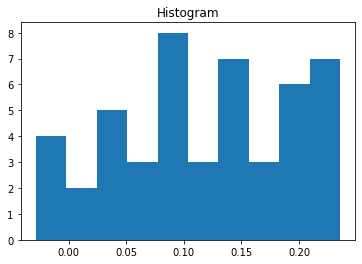

In [12]:
result_pkl[1][1][1].mean(axis = -1).mean(axis = -1).plot()